In [2]:
import torch
import torch.nn as nn
import numpy as np
from sympy import *
import torch
import torch.nn as nn
import torch as numpy
import torch .nn as np 
import torch.nn.functional as F
import numpy as np
import torch.distributions as dist
import math 
from scipy.special import gamma
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import math
import matplotlib.pyplot as plt
import scipy.integrate as spi

In [32]:
class FNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim) -> None:
        super(FNN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            #nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
                        #nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, inputs):
        #print(inputs,self.mlp(inputs))
        return self.mlp(inputs)

In [33]:
class deepBSDE(nn.Module):
    def __init__(self, T, N, alpha, r, f, g) -> None:
        super(deepBSDE,self).__init__()
        self.alpha = alpha
        self.f = f
        self.g = g
        self.r = r
        self.N = N
        self.T = T
        self.delta_t = T / N
        self.u = nn.ModuleList([FNN(1,1,10) for _ in range(N)])
        self.c = 2**alpha*torch.tensor(float(gamma((1+alpha)/2))) / np.pi**(1/2) / torch.abs(torch.tensor(float(gamma(-alpha / 2))))
        self.lamb = 2 * self.c / alpha / r**alpha
        self.k = torch.tensor(np.pi**(1/2)*r**(2-alpha) / float(gamma(1/2 +1)) / (2 - alpha))


In [34]:
class deepBSDE(nn.Module):
    def __init__(self, T, N, alpha, r, f, g) -> None:
        super(deepBSDE,self).__init__()
        self.alpha = alpha
        self.f = f
        self.g = g
        self.r = r
        self.N = N
        self.T = T
        self.delta_t = T / N
        self.u = nn.ModuleList([FNN(1,1,10) for _ in range(N)])
        self.c = 2**alpha*torch.tensor(float(gamma((1+alpha)/2))) / np.pi**(1/2) / torch.abs(torch.tensor(float(gamma(-alpha / 2))))
        self.lamb = 2 * self.c / alpha / r**alpha
        self.k = torch.tensor(np.pi**(1/2)*r**(2-alpha) / float(gamma(1/2 +1)) / (2 - alpha))

    def forward(self, n, X,batch):
        # sample the forward process at time tn
        tn = torch.tensor(self.delta_t*n)
        Bn = torch.randn([batch,1])*torch.sqrt(tn)
        Xn = X + torch.sqrt(self.c*self.k)*Bn
        Pn = torch.poisson(tn*self.lamb).int()
        for _ in range(Pn):
            a = torch.randint(0,2,[batch,1]) - 1
            b = torch.rand([batch,1])
            J = a*self.r / (1 - b)**(1/self.alpha)
            Xn = Xn + J
        
        # delta_Bn = torch.randn([1,1])*torch.sqrt(torch.tensor(self.delta_t))
        # Xn1 = Xn + torch.sqrt(self.c*self.k)*delta_Bn

        # sample the jumps and process in the interval [tn,tn+1)
        j = 0
        s = [tn]
        XX = [Xn]
        delta_Bn = 0
        while s[j] < tn+self.delta_t:
            a = torch.rand([1])
            tau = -torch.log(1 - a) / self.lamb
            a = torch.randint(0,2,[batch,1]) - 1
            b = torch.rand([batch,1])
            delta_Xj = a*self.r / (1 - b)**(1/self.alpha)
            s.append(s[j] + tau)
            delta_Bj = torch.randn([batch,1])*torch.sqrt(tau)
            delta_Bn = delta_Bn + delta_Bj
            XX.append(XX[j] + delta_Xj + torch.sqrt(self.c*self.k)*delta_Bj)
            j = j + 1
        delta_B1 = torch.randn([batch,1])*torch.sqrt(tn+self.delta_t-s[j-1])
        Xn1 = XX[j-1] + torch.sqrt(self.c*self.k)*delta_B1
        delta_Bn = delta_Bn - delta_Bj + delta_B1

        # compute g and u
        if n == self.N-1:
            g = self.g(Xn1)
        else:
            g = self.u[n+1](Xn1).detach()
        Xn = Xn.requires_grad_(True)
        u = self.u[n](Xn)
        f = self.f(tn,Xn,u)
        for i in range(j - 2):
            ui1 = self.u[n](XX[i])
            ui11 = self.u[n](XX[i+1])
            if n == self.N-1:
                ui2 = self.g(XX[i])
                ui22 = self.g(XX[i+1])
            else:
                ui2 = self.u[n+1](XX[i]).detach()
                ui22 = self.u[n+1](XX[i+1]).detach()
            u = u + self.linear_inter(s[i+1],ui11,ui22,tn) - self.linear_inter(s[i+1],ui1,ui2,tn)
        grad_u = torch.autograd.grad(
            u,
            Xn,
            torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u = u + torch.sqrt(self.c*self.k) * grad_u*delta_Bn
        u = u - f*self.delta_t
        return u, g
    
    def linear_inter(self, s, u1, u2, tn):
        return ((s - tn) * u2 + (tn + self.delta_t - s) * u1) / self.delta_t

In [36]:
import numpy as np
import scipy.integrate as scipyint
from sympy import *
## define some important vlaues in the loop
inf = 10**7
r = 0.0001

alpha = 0.7
d = 1

def nu_alpha(x, alpha, d, r):
    numerator3 = 2**alpha * gamma((d + alpha) / 2)
    denominator3 = math.pi**(d / 2) * abs(gamma(-alpha / 2))
    if abs(x) > r:
        res = numerator3 / denominator3 / (np.abs(x) ** (d + alpha))
    else:
        res = 0
    return  res

def integrand(x, alpha, d, r):
    return (np.cos(x) - 1)*nu_alpha(x,alpha,d,r)

res, err = scipyint.quad(lambda x:integrand(x,alpha=alpha,d=d,r=r), -np.inf, np.inf)
integral_value = torch.tensor(res)

def g(x,T):
    return torch.sin(x) * torch.exp(-T**2)
def f(t,x,u):
    return torch.sin(x) *(-2)*t* torch.exp(-t**2) - u

res_values=[]
def train(model, epoch, x, batch_size):
    T = model.T
    N = model.N
    
    optim = [torch.optim.Adam(model.u[i].parameters(),lr=0.001) for i in range(N)]
    loss_fun = nn.MSELoss()

    loss_values = torch.zeros([N, epoch])
    #loss_values=[]
    for i in range(N):
        model.eval()
        for j in range(epoch):
            model.u[N-i-1].train()
            optim[N-i-1].zero_grad()
            u,g = model(N-i-1,x.view(batch_size, -1),batch_size)
            #u,g = model(N-i-1,x.view(batch_size),batch_size)
            
            loss = loss_fun(u,g)
            loss.backward()
            optim[N-i-1].step()

            model.eval()
            loss_values[i,j] = loss.item()
            #res_values = []
            print("N:",i,"epoch:",j,"loss:",loss_values[i,j],"res:",model.u[0](x.view(batch_size, -1))[0,0].detach())
            #res_values.append(res_values.item())
            res_value = model.u[0](x.view(batch_size, -1))[0,0].detach()

            res_values.append(res_value.item())
    return loss_values

C:\Users\umaiskhan\AppData\Local\Temp\ipykernel_14236\3473128199.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = scipyint.quad(lambda x:integrand(x,alpha=alpha,d=d,r=r), -np.inf, np.inf)


In [37]:
# Create an instance of the deepBSDE class
T = 0.1
#x = torch.tensor([[-0.5]])
x = torch.full((64, 1), -0.5)
#x = torch.randn(64, 1)*0.5  # Generate random inputs
model = deepBSDE(T=T, N=5, alpha=alpha, r=0.5, f=f, g=lambda x:g(x,torch.tensor(T)))
# Train the model
loss_values = train(model, epoch=5000, x=x, batch_size=64)

N: 0 epoch: 0 loss: tensor(0.2407) res: tensor(0.3182)
N: 0 epoch: 1 loss: tensor(0.2524) res: tensor(0.3182)
N: 0 epoch: 2 loss: tensor(0.2337) res: tensor(0.3182)
N: 0 epoch: 3 loss: tensor(0.2429) res: tensor(0.3182)
N: 0 epoch: 4 loss: tensor(0.1956) res: tensor(0.3182)
N: 0 epoch: 5 loss: tensor(0.1996) res: tensor(0.3182)
N: 0 epoch: 6 loss: tensor(0.1996) res: tensor(0.3182)
N: 0 epoch: 7 loss: tensor(0.1706) res: tensor(0.3182)
N: 0 epoch: 8 loss: tensor(0.1698) res: tensor(0.3182)
N: 0 epoch: 9 loss: tensor(0.1567) res: tensor(0.3182)
N: 0 epoch: 10 loss: tensor(0.4789) res: tensor(0.3182)
N: 0 epoch: 11 loss: tensor(0.1607) res: tensor(0.3182)
N: 0 epoch: 12 loss: tensor(0.1703) res: tensor(0.3182)
N: 0 epoch: 13 loss: tensor(0.1334) res: tensor(0.3182)
N: 0 epoch: 14 loss: tensor(0.1297) res: tensor(0.3182)
N: 0 epoch: 15 loss: tensor(0.1390) res: tensor(0.3182)
N: 0 epoch: 16 loss: tensor(0.1117) res: tensor(0.3182)
N: 0 epoch: 17 loss: tensor(0.4605) res: tensor(0.3182)
N:

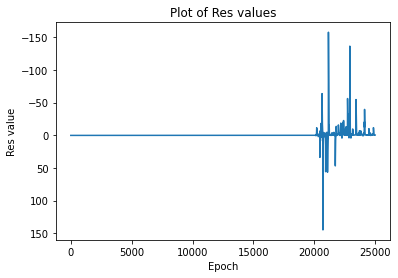

In [38]:
import matplotlib.pyplot as plt
plt.plot(res_values)
plt.xlabel('Epoch')
plt.ylabel('Res value')
plt.title('Plot of Res values')
plt.gca().invert_yaxis()
plt.show()

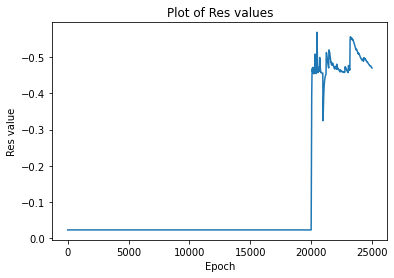

In [31]:
import matplotlib.pyplot as plt
plt.plot(res_values)
plt.xlabel('Epoch')
plt.ylabel('Res value')
plt.title('Plot of Res values')
plt.gca().invert_yaxis()
plt.show()

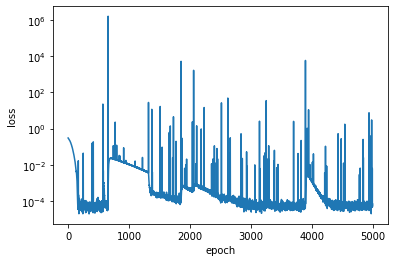

In [10]:
#plot graph of N=1 loss in log scale from 10^-4 to 10^2
plt.semilogy(loss_values[4,:])
#y axes limit from 10^-4 to 10^2
#plt.ylim(10**(-4),10**2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

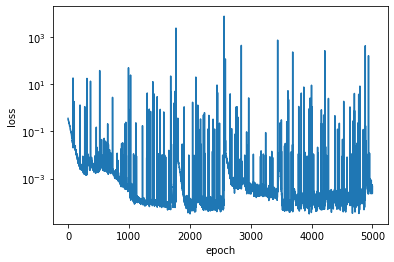

In [11]:
#plot graph of N=3 loss in log scale from 10^-4 to 10^2
plt.semilogy(loss_values[3,:])
#y axes limit from 10^-4 to 10^2
#plt.ylim(10**(-4),10**2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()